In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict

import os 

import matplotlib.pyplot as plt

#NameFile
class NameFile():
    @staticmethod#static? iets met dat je m kan callen using the class itself. don't need an instance of the class, to call the method. i guess dat je m dus niet eerst hoeft te initieren alszijnde type x? 
    def nameit(params): #ga er dus vanuit dat je alleen keys and values hebt, dus alleen 0 en 1 voor die ene index. wellicht gaat dit dus ooit mis, makkelijk te herstellen

        items_hier = list(params.items()) #keys+values
        num_k=0 #amount of keys present
        comment = '' #the string for the filename
        
        #make the comment by looping over keys and values
        for k in params.keys():
            comment += f'{items_hier[num_k][0]}=' #add the key
            for v in items_hier[num_k][1]:
                comment +=(f'{v}_') #add the values
            num_k+=1 #for indexing next loop to get next keys/values in list
        comment+='results'
        return comment

#RunBuilder
class RunBuilder():
    @staticmethod#static? iets met dat je m kan callen using the class itself. don't need an instance of the class, to call the method. i guess dat je m dus niet eerst hoeft te initieren alszijnde type x? 
    def get_runs(params):
        
        Run = namedtuple('Run',params.keys())#die ordereddicttionary heeft keys and values. dit heb je wel eens eerder gezien I guess.
                                             #blijkbaar maakt ie een mooie string als je die keys zo oproept. test dat even.
        
        runs = []
        for v in product(*params.values()): #dit doet dus iets dat ie per value combo nieuwe iteratie doet
            runs.append(Run(*v))
            
        return runs

#RunManager
class RunManager():
    def __init__(self):
        
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None

    def begin_run(self,run,network,loader): #die self is dus gewoon de variabel naam links van de streep
        #start time for a run, parameters run added, run_count+1 (stays same for all epochs)
        #network copied, loader copied, name given in tb. 
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images,labels = next(iter(self.loader)) #misschien wel gewoon plaatjes inladen voor foto'tje in tensorboard
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images',grid)
        self.tb.add_graph(
            self.network
            ,images.to(getattr(run,'device','cpu')))
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        
        epoch_duration = time.time()-self.epoch_start_time
        run_duration = time.time()-self.run_start_time
        
        loss = self.epoch_loss/len(self.loader.dataset)
        accuracy = self.epoch_num_correct/len(self.loader.dataset)
        
        self.tb.add_scalar('Loss',loss,self.epoch_count)
        self.tb.add_scalar('Accuracy',accuracy,self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name,param,self.epoch_count)
            self.tb.add_histogram(f'{name}.grad',param.grad,self.epoch_count)
            
        results = OrderedDict()
        results["run"]=self.run_count
        results["epoch"]=self.epoch_count
        results["loss"]=loss
        results["accuracy"]=accuracy
        results["epoch duration"]=epoch_duration
        results["run duration"]=run_duration
                            
        for k,v in self.run_params._asdict().items():  #deze komen uit run, je batch_size & lr
            results[k] = v #geloof dat je hier dus voor elke run met andere batch size etc. maar 1 lr en batchsize toevoegt, vandaar dat dit niet in de loop zit
        self.run_data.append(results) #1 batch_size en lr bij de results bij, en vervolgens voeg je al je results toe aan wat je metadata i guess
        df = pd.DataFrame.from_dict(self.run_data,orient='columns') #dit zorgt dat het in een leuk tabelletje staat
                                
        clear_output(wait=True)
        display(df)
                                
    def track_loss(self,loss):
            self.epoch_loss += loss.item()* self.loader.batch_size
                                    
    def track_num_correct(self,preds,labels):
            self.epoch_num_correct += self._get_num_correct(preds,labels)
        
    @torch.no_grad()
    def _get_num_correct(self,preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self,fileName,ResDir,file_num):
        
        os.mkdir(f'{ResDir}\{file_num}')
        
        pd.DataFrame.from_dict(
        self.run_data
        ,orient = 'columns'
        ).to_csv(f'{ResDir}\{file_num}\{fileName}.csv')
        
        with open(f'{ResDir}\{file_num}\{fileName}.json','w',encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

#Network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t,dim=1)

        return t

In [5]:
#Starting parameter values
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()
                                                                                         ])
)

params = OrderedDict(
    lr = [.01]
    ,batch_size = [1000, 10000, 20000]
    ,num_workers = [0, 1]
    , device = ['cuda','cpu']
)

ResDir = 'runs_results'
file_num = '1009_1438'
m=RunManager()


In [6]:
#the actual network looping
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(train_set,batch_size=run.batch_size,num_workers = run.num_workers)
    optimiser = optim.Adam(network.parameters(),lr=run.lr)
    
    m.begin_run(run,network,loader)
    for epoch in range(1):
        m.begin_epoch()
        for batch in loader:
            
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images) #pass batch
            loss = F.cross_entropy(preds,labels)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save(NameFile.nameit(params),ResDir,file_num) #mooie naam voor de results file met alle parameter values erin

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device
0,1,1,1.132866,0.562100,5.217751,8.581563,0.01,1000,0,cuda
1,2,1,0.968032,0.625517,8.740240,9.472870,0.01,1000,0,cpu
2,3,1,0.987695,0.623300,6.053678,7.371680,0.01,1000,1,cuda
3,4,1,1.051103,0.600167,6.135222,7.522246,0.01,1000,1,cpu
4,5,1,2.132067,0.255617,7.451844,11.861963,0.01,10000,0,cuda
5,6,1,2.189170,0.167250,16.781688,30.139158,0.01,10000,0,cpu
6,7,1,2.209276,0.202500,7.173644,15.076800,0.01,10000,1,cuda
7,8,1,2.171549,0.159533,19.416427,30.787374,0.01,10000,1,cpu
8,9,1,2.294909,0.147250,18.883495,32.927521,0.01,20000,0,cuda
9,10,1,2.260317,0.248033,21.019056,44.650243,0.01,20000,0,cpu


In [4]:
loader = DataLoader(train_set,batch_size=len(train_set),num_workers = 1)
data = next(iter(loader))
mean=data[0].mean()
std=data[0].std()

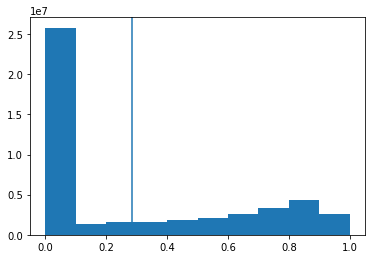

In [5]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())


In [6]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    , train=True
    , download=True
    , transform=transforms.Compose([
          transforms.ToTensor()
        , transforms.Normalize(mean,std)
    ])
)

In [7]:
loader = DataLoader(train_set,batch_size=len(train_set),num_workers = 1)
data = next(iter(loader))
data[0].mean(),data[0].std()

(tensor(0.2861), tensor(0.3530))

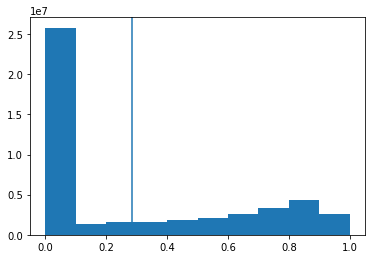

In [8]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())


In [9]:
trainsets = {
    'not_normal': train_set
    ,'normal':train_set_normal
}

In [10]:
params = OrderedDict(
    lr = [.01]
    ,batch_size = [1000]
    ,num_workers = [1]
    , device = ['cuda']
    , trainset = ['not_normal','normal']
)
file_num = '1208_1737_2'
m=RunManager()


In [11]:
#the actual network looping
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(trainsets[run.trainset],batch_size=run.batch_size,num_workers = run.num_workers)
    optimiser = optim.Adam(network.parameters(),lr=run.lr)
    
    m.begin_run(run,network,loader)
    for epoch in range(20):
        m.begin_epoch()
        for batch in loader:
            
            images = batch[0].to(device)
            print(batch[0])
            print(batch[0].shape)
            print(batch[0].shape[0])
            labels = batch[1].to(device)
            preds = network(images) #pass batch
            loss = F.cross_entropy(preds,labels)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            m.track_loss(loss) #hij geeft sinds die cuda unit batch mee, om batch[0].shape[0] mee te geven als batchsize. zou niet weten waarom self.loader.batch_size ineens niet meer zou werken. iets met als het niet deelbaar door batchsize is werkt dit nog. zou je iets langer over na moeten denken i guess
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save(NameFile.nameit(params),ResDir,file_num) #mooie naam voor de results file met alle parameter values erin

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
0,1,1,1.038172,0.608183,6.425783,8.297614,0.01,1000,1,cuda,not_normal
1,1,2,0.540648,0.792867,6.365275,14.747993,0.01,1000,1,cuda,not_normal
2,1,3,0.446436,0.835783,6.513255,21.348121,0.01,1000,1,cuda,not_normal
3,1,4,0.394151,0.855233,6.613685,28.059463,0.01,1000,1,cuda,not_normal
4,1,5,0.365182,0.865600,6.751827,34.917877,0.01,1000,1,cuda,not_normal
5,1,6,0.341345,0.873550,6.535502,41.558200,0.01,1000,1,cuda,not_normal
6,1,7,0.326403,0.878867,6.365761,48.010893,0.01,1000,1,cuda,not_normal
7,1,8,0.314082,0.882150,6.571149,54.662834,0.01,1000,1,cuda,not_normal
8,1,9,0.306082,0.886050,6.412692,61.157604,0.01,1000,1,cuda,not_normal
9,1,10,0.300655,0.887183,6.371709,67.611968,0.01,1000,1,cuda,not_normal


In [12]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy',ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset
39,2,20,0.218308,0.917683,9.721998,200.655358,0.01,1000,1,cuda,normal
38,2,19,0.218067,0.917167,9.430971,190.816723,0.01,1000,1,cuda,normal
37,2,18,0.221382,0.917083,9.737336,181.289772,0.01,1000,1,cuda,normal
36,2,17,0.223033,0.916217,9.553399,171.450259,0.01,1000,1,cuda,normal
35,2,16,0.227589,0.914100,9.672237,161.796700,0.01,1000,1,cuda,normal
34,2,15,0.235897,0.910750,13.229216,151.976044,0.01,1000,1,cuda,normal
18,1,19,0.239480,0.909917,6.428524,129.286069,0.01,1000,1,cuda,not_normal
33,2,14,0.242909,0.908850,10.583912,138.576680,0.01,1000,1,cuda,normal
19,1,20,0.241451,0.907700,6.683687,136.059168,0.01,1000,1,cuda,not_normal
17,1,18,0.247809,0.906600,6.802097,122.771563,0.01,1000,1,cuda,not_normal


# Trying multiple networks 39

In [13]:
torch.manual_seed(50)
network1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    ,nn.ReLU()
    ,nn.MaxPool2d(kernel_size=2,stride=2)
    ,nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    ,nn.ReLU()
    ,nn.MaxPool2d(kernel_size=2,stride=2)
    ,nn.Flatten(start_dim=1)
    ,nn.Linear(in_features=12*4*4,out_features=120)
    ,nn.ReLU()
    ,nn.Linear(in_features=120,out_features=60)
    ,nn.ReLU()
    ,nn.Linear(in_features=60,out_features=10)   
)

In [14]:
torch.manual_seed(50)
network2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    ,nn.ReLU()
    ,nn.MaxPool2d(kernel_size=2,stride=2)
    ,nn.BatchNorm2d(6)
    ,nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    ,nn.ReLU()
    ,nn.MaxPool2d(kernel_size=2,stride=2)
    ,nn.Flatten(start_dim=1)
    ,nn.Linear(in_features=12*4*4,out_features=120)
    ,nn.ReLU()
    ,nn.BatchNorm1d(120)
    ,nn.Linear(in_features=120,out_features=60)
    ,nn.ReLU()
    ,nn.Linear(in_features=60,out_features=10)   
)

In [15]:
train_set = torchvision.datasets.FashionMNIST(
root='./data'
    ,download=True
    ,train=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)


In [16]:
loader = DataLoader(train_set,batch_size=len(train_set),num_workers=1)
data=next(iter(loader))
mean = data[0].mean()
std = data[0].std()
mean,std

(tensor(0.2861), tensor(0.3530))

In [17]:
train_set_normal = torchvision.datasets.FashionMNIST(
root='./data'
    ,download=True
    ,train=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
        ,transforms.Normalize(mean,std)
    ])
)


In [18]:
trainsets = {
    'not-normal': train_set
    ,'normal':train_set_normal
}

In [19]:
networks = {
    'network1': network1
    ,'network2':network2
}

In [ ]:
params = OrderedDict(
lr = [.01]
,batch_size = [1000]
,num_workers = [1]
,device = ['cuda']
,trainset = ['normal']
,network=list(networks.keys())
)
ResDir = 'runs_results'
file_num = '1208_1737_3'
m=RunManager()

#the actual network looping
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(trainsets[run.trainset],batch_size=run.batch_size,num_workers = run.num_workers)
    optimiser = optim.Adam(network.parameters(),lr=run.lr)
    
    m.begin_run(run,network,loader)
    for epoch in range(20):
        m.begin_epoch()
        for batch in loader:
            
            images = batch[0].to(device)
            print(batch[0])
            print(batch[0].shape)
            print(batch[0].shape[0])
            labels = batch[1].to(device)
            preds = network(images) #pass batch
            loss = F.cross_entropy(preds,labels)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            m.track_loss(loss) #hij geeft sinds die cuda unit batch mee, om batch[0].shape[0] mee te geven als batchsize. zou niet weten waarom self.loader.batch_size ineens niet meer zou werken
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save(NameFile.nameit(params),ResDir,file_num) #mooie naam voor de results file met alle parameter values erin

Exception in thread Thread-20:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 238, in run
    self._record_writer.write(data)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 101, in write
    self._prewrite_check()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 87, in _prewrite_check
    compat.as_bytes(self.__name), compat.as_bytes(self.__mode))
tensorflow.python.framework.errors_impl.NotFoundError: Failed to create a NewWriteableFile: runs\Aug12_17-47-54_DESKTOP-MF25I58-Run(lr=0.01, batch_size=1000, num_workers=1, device='cuda', 

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.6993,  1.6668,  ...,  1.3780, -0.8104, -0.8104],
          [-0.8104, -0.8104,  1.1558,  ..., -0.2328, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.7660, -0.8104, -0.8104],
          ...,
          [ 0.3560,  1.6779,  1.0892,  ...,  1.2336,  0.4004, -0.5216],
          [-0.8104, -0.4771,  0.6004,  ..., -0.1328, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ...,  1.3558,  1.6001, -0.2772],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.7882, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.7771, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.0995,  ..., -0.1328, -0.8104, -0.7549],
          [-0.7993, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.7993],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810

tensor([[[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          ...,
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104]]],


        [[[-0.8104, -0.8104, -0.8104,  ..., -0.8104, -0.8104, -0.8104],
          [-0.8104, -0.810